In [2]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 103.5 MB/s eta 0:00:00


In [3]:
from typing import Dict, List, Tuple, Optional
import math
import numpy as np
import pulp as pl

try:
    import matplotlib.pyplot as plt
except:
    plt = None

In [4]:
from typing import Dict, List, Tuple, Optional
import math
import numpy as np

try:
    import matplotlib.pyplot as plt
except Exception:
    plt = None


class TresBolillosSpace:
    DEFAULT_SPECIES = [
        "Agave lechuguilla",
        "Agave salmiana",
        "Agave scabra",
        "Agave striata",
        "Opuntia cantabrigiensis",
        "Opuntia engelmannii",
        "Opuntia robusta",
        "Opuntia streptacantha",
        "Prosopis laevigata",
        "Yucca filifera",
    ]

    DEFAULT_SPECIES_PROBS = {
        "Agave lechuguilla":        0.06326106326,
        "Agave salmiana":           0.295133438,
        "Agave scabra":             0.06203063346,
        "Agave striata":            0.05956977386,
        "Opuntia cantabrigiensis":  0.07772922059,
        "Opuntia engelmannii":      0.06190334762,
        "Opuntia robusta":          0.1165089737,
        "Opuntia streptacantha":    0.09711909712,
        "Prosopis laevigata":       0.1280495566,
        "Yucca filifera":           0.03869489584,
    }

    def __init__(self, mode="rect", rows=14, cols=47, n_sites=658,
                 p_occupied=0.1963257453, species=None, species_probs=None, seed=None):
        self.mode = mode
        self.rows = rows
        self.cols = cols
        self.n_sites = n_sites
        self.p_occupied = float(p_occupied)
        self.species = list(species) if species is not None else list(self.DEFAULT_SPECIES)
        self.species_probs = dict(species_probs) if species_probs is not None else dict(self.DEFAULT_SPECIES_PROBS)
        self.seed = seed

        self.N, self.edges = self._build_graph()
        self.n = len(self.N)

        self.y_init = None
        self.species_init = None
        self.counts = None

    @classmethod
    def from_rect(cls, rows=14, cols=47, **kwargs):
        return cls(mode="rect", rows=rows, cols=cols, n_sites=rows * cols, **kwargs)

    @classmethod
    def from_disk(cls, n_sites=658, **kwargs):
        return cls(mode="disk", n_sites=n_sites, **kwargs)

    def _build_graph(self):
        if self.mode == "rect":
            return self._build_hex_edges_rect(self.rows, self.cols)
        elif self.mode == "disk":
            return self._build_hex_edges_n(self.n_sites)
        raise ValueError("mode debe ser 'rect' o 'disk'.")

    @staticmethod
    def _build_hex_edges_rect(rows, cols):
        n_sites = rows * cols
        N = list(range(n_sites))
        E = set()
        for r in range(rows):
            for c in range(cols):
                u = r * cols + c
                cand = [(r, c - 1), (r, c + 1), (r - 1, c), (r + 1, c)]
                cand += [(r - 1, c - 1), (r + 1, c - 1)] if (r % 2 == 0) else [(r - 1, c + 1), (r + 1, c + 1)]
                for rr, cc in cand:
                    if 0 <= rr < rows and 0 <= cc < cols:
                        v = rr * cols + cc
                        if u < v:
                            E.add((u, v))
        return N, sorted(E)

    @staticmethod
    def _build_hex_edges_n(n_sites):
        def hex_count(R): return 1 + 3 * R * (R + 1)
        R = 0
        while hex_count(R) < n_sites:
            R += 1
        coords = []
        for q in range(-R, R + 1):
            rmin = max(-R, -q - R)
            rmax = min(R, -q + R)
            for r in range(rmin, rmax + 1):
                coords.append((q, r))
        coords = coords[:n_sites]
        coord_to_id = {coords[i]: i for i in range(n_sites)}
        N = list(range(n_sites))
        dirs = [(1, 0), (1, -1), (0, -1), (-1, 0), (-1, 1), (0, 1)]
        E = set()
        for u in N:
            q, r = coords[u]
            for dq, dr in dirs:
                v = coord_to_id.get((q + dq, r + dr))
                if v is not None and u < v:
                    E.add((u, v))
        return N, sorted(E)

    def _normalized_probs(self):
        p = np.array([self.species_probs[name] for name in self.species], dtype=float)
        s = p.sum()
        if s <= 0:
            raise ValueError("La suma de probabilidades de especies debe ser > 0.")
        return p / s

    def sample_initial(self, seed=None):
        rng = np.random.default_rng(self.seed if seed is None else seed)
        y = (rng.random(self.n) < self.p_occupied).astype(int)
        species_init = np.full(self.n, -1, dtype=int)
        k = int(y.sum())
        if k > 0:
            draws = rng.choice(len(self.species), size=k, p=self._normalized_probs())
            species_init[y == 1] = draws
        self.y_init = y
        self.species_init = species_init
        self.counts = {self.species[i]: int((species_init == i).sum()) for i in range(len(self.species))}

    def to_pulp(self):
        return self.N, self.edges, self.species

    @staticmethod
    def add_preplanted_constraints_pulp(model, x, N, species_init, n_species):
        import pulp as pl
        for u in N:
            i_star = int(species_init[u])
            if i_star >= 0:
                model += x[(u, i_star)] == 1
                for j in range(n_species):
                    if j != i_star:
                        model += x[(u, j)] == 0

    def _positions_rect(self, spacing=1.0):
        dx = spacing * 0.5
        dy = spacing * math.sqrt(3) / 2
        pts = []
        for r in range(self.rows):
            for c in range(self.cols):
                x = c * spacing + (dx if r % 2 else 0.0)
                y = r * dy
                pts.append((x, y))
        return np.array(pts)

    def _positions_disk(self, spacing=1.0):
        def hex_count(R): return 1 + 3 * R * (R + 1)
        R = 0
        while hex_count(R) < self.n:
            R += 1
        coords = []
        for q in range(-R, R + 1):
            rmin = max(-R, -q - R)
            rmax = min(R, -q + R)
            for r in range(rmin, rmax + 1):
                coords.append((q, r))
        coords = coords[:self.n]
        pts = []
        rt3_2 = math.sqrt(3) / 2
        for (q, r) in coords:
            x = q + 0.5 * r
            y = rt3_2 * r
            pts.append((spacing * x, spacing * y))
        return np.array(pts)

    def plot(self, spacing=1.0, show_edges=True, figsize=(12, 5),
             point_size_empty=10, point_size_occ=28):
        if plt is None:
            raise RuntimeError("Matplotlib no está disponible.")
        from matplotlib.colors import BoundaryNorm
        pos = self._positions_rect(spacing) if self.mode == "rect" else self._positions_disk(spacing)
        fig, ax = plt.subplots(figsize=figsize)
        if show_edges:
            for (u, v) in self.edges:
                x1, y1 = pos[u]; x2, y2 = pos[v]
                ax.plot([x1, x2], [y1, y2], lw=0.4, alpha=0.25, color="#6a9fb5")
        if self.y_init is None or self.species_init is None:
            ax.scatter(pos[:, 0], pos[:, 1], s=18, alpha=0.9, color="#4f83cc")
        else:
            empty = (self.y_init == 0)
            if np.any(empty):
                ax.scatter(pos[empty, 0], pos[empty, 1], s=point_size_empty, alpha=0.5, color="#b0c4de")
            occ = (self.y_init == 1)
            if np.any(occ):
                cmap = plt.get_cmap("tab10")
                boundaries = np.arange(-0.5, len(self.species) + 0.5, 1.0)
                norm = BoundaryNorm(boundaries, cmap.N)
                sc = ax.scatter(pos[occ, 0], pos[occ, 1], s=point_size_occ,
                                c=self.species_init[occ], cmap=cmap, norm=norm, alpha=0.95, edgecolors="none")
                cbar = fig.colorbar(sc, ax=ax, ticks=np.arange(len(self.species)), fraction=0.03, pad=0.02)
                cbar.ax.set_yticklabels(self.species)
                cbar.set_label("Especie", rotation=90)
                cbar.ax.tick_params(labelsize=9)
        ax.set_aspect("equal")
        ax.axis("off")
        fig.tight_layout()
        plt.show()

    def pre_counts(self):
        if self.species_init is None:
            return {name: 0 for name in self.species}
        counts = {name: 0 for name in self.species}
        for idx in self.species_init:
            if idx >= 0:
                counts[self.species[idx]] += 1
        return counts

    def quota_bands_total(self, targets, tol=0.05):
        bands = {}
        for name in self.species:
            Ti = int(targets[name])
            Li = math.floor((1.0 - tol) * Ti)
            Ui = math.ceil((1.0 + tol) * Ti)
            bands[name] = {"T": Ti, "L": Li, "U": Ui}
        return bands

    def remaining_bands(self, targets, tol=0.05):
        bands = self.quota_bands_total(targets, tol)
        pre = self.pre_counts()
        free_slots = int(self.n - (self.y_init.sum() if self.y_init is not None else 0))
        rem = {}
        infeasible = []
        for name, bu in bands.items():
            P = pre.get(name, 0)
            Lp = max(0, bu["L"] - P)
            Up = max(0, bu["U"] - P)
            if P > bu["U"]:
                infeasible.append((name, f"pre={P} > U={bu['U']}"))
            rem[name] = {"pre": P, "L_rem": Lp, "U_rem": Up}
        min_needed = sum(v["L_rem"] for v in rem.values())
        max_allow = sum(v["U_rem"] for v in rem.values())
        checks = {
            "free_slots": free_slots,
            "sum_L_rem": min_needed,
            "sum_U_rem": max_allow,
            "min_feasible_given_free?": (min_needed <= free_slots),
            "max_feasible_given_free?": (free_slots <= max_allow),
            "species_over_cap": infeasible,
        }
        return rem, checks


In [5]:
!pip install joblib


🔧 Construyendo y resolviendo el modelo global...

🎯 Targets verificados (±10%):
Agave lechuguilla        :   9  target= 42  rango=(39-45) ❌
Agave salmiana           : 112  target=196  rango=(186-206) ❌
Agave scabra             :  15  target= 42  rango=(39-45) ❌
Agave striata            :  14  target= 42  rango=(39-45) ❌
Opuntia cantabrigiensis  :  34  target= 49  rango=(46-52) ❌
Opuntia engelmannii      :  18  target= 38  rango=(36-40) ❌
Opuntia robusta          :  52  target= 73  rango=(69-77) ❌
Opuntia streptacantha    :  36  target= 64  rango=(60-68) ❌
Prosopis laevigata       :  72  target= 86  rango=(81-91) ❌
Yucca filifera           :  21  target= 26  rango=(24-28) ❌

✅ Modelo global resuelto. Totales globales:
  Agave lechuguilla        :   9  (target= 42)
  Agave salmiana           : 112  (target=196)
  Agave scabra             :  15  (target= 42)
  Agave striata            :  14  (target= 42)
  Opuntia cantabrigiensis  :  34  (target= 49)
  Opuntia engelmannii      :  18  (tar

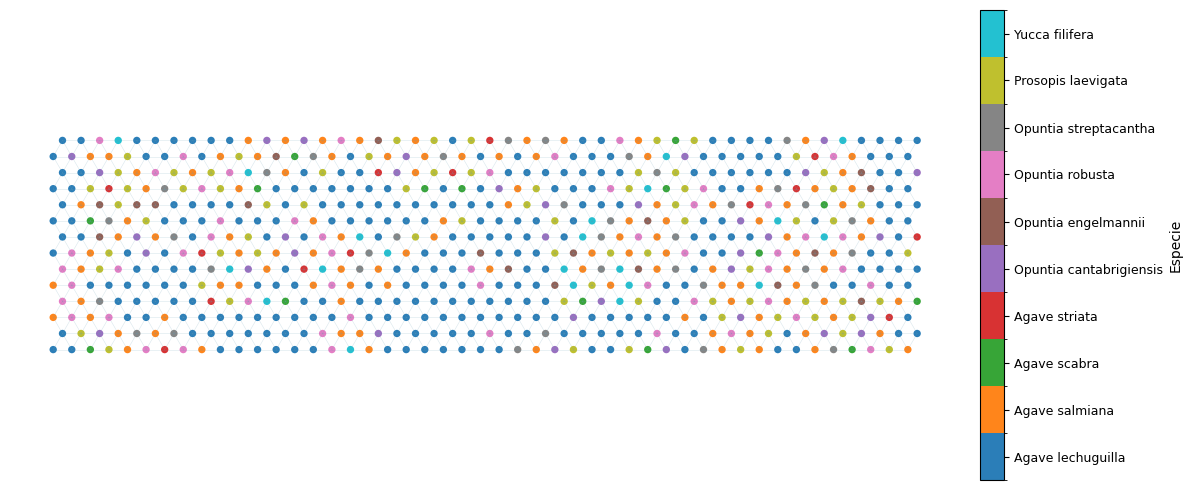

In [6]:
from typing import Dict
import numpy as np
import math
import csv
from collections import Counter
import pulp as pl

# =============================
# 🔹 Datos globales
# =============================

TARGETS = {
    "Agave lechuguilla":        42,
    "Agave salmiana":          196,
    "Agave scabra":             42,
    "Agave striata":            42,
    "Opuntia cantabrigiensis":  49,
    "Opuntia engelmannii":      38,
    "Opuntia robusta":          73,
    "Opuntia streptacantha":    64,
    "Prosopis laevigata":       86,
    "Yucca filifera":           26,
}
assert sum(TARGETS.values()) == 658

P_NOT_SURV = {
    "Agave lechuguilla":        0.03675,
    "Agave salmiana":           0.04590,
    "Agave scabra":             0.12735,
    "Agave striata":            0.04310,
    "Opuntia cantabrigiensis":  0.08565,
    "Opuntia engelmannii":      0.09030,
    "Opuntia robusta":          0.04010,
    "Opuntia streptacantha":    0.07375,
    "Prosopis laevigata":       0.09105,
    "Yucca filifera":           0.13685,
}

TOL = 0.05
ALPHA_COMP = 1.0
BETA_SURV  = 1.0


#  Función auxiliar: escalado proporcional de targets


def downscale_targets_exact(original: Dict[str, int], new_total: int) -> Dict[str, int]:
    """Escala las cuotas proporcionalmente para un subproblema."""
    items = [(k, v) for k, v in original.items() if v > 0]
    if not items:
        return {k: 0 for k in original}
    tot_old = sum(v for _, v in items)
    shares = [(k, v * new_total / tot_old) for k, v in items]
    base = {k: int(math.floor(s)) for k, s in shares}
    remainder = new_total - sum(base.values())
    fracs = sorted(((k, s - base[k]) for k, s in shares), key=lambda x: x[1], reverse=True)
    for i in range(remainder):
        base[fracs[i][0]] += 1
    for k in original:
        if k not in base:
            base[k] = 0
    return base


#  Función principal: construir y resolver el MILP


def build_and_solve(space, targets: Dict[str, int], p_not_surv: Dict[str, float],
                    tol: float = 0.10, alpha_comp: float = 1.0, beta_surv: float = 1.0,
                    solver=None, relax_x: bool = False):
    """Construye y resuelve el MILP global con targets ±10% respetados estrictamente."""
    N, edges, species = space.to_pulp()
    n_nodes = len(N)
    n_species = len(species)

    surv = {name: 1.0 - float(p_not_surv[name]) for name in species}

    # Matriz de competencia (igual que antes)
    C = np.array([
        [1.0, 0.8, 0.8, 0.8, 0.3, 0.3, 0.3, 0.3, 0.5, 0.2],
        [0.8, 1.0, 0.8, 0.8, 0.3, 0.3, 0.3, 0.3, 0.5, 0.2],
        [0.8, 0.8, 1.0, 0.8, 0.3, 0.3, 0.3, 0.3, 0.5, 0.2],
        [0.8, 0.8, 0.8, 1.0, 0.3, 0.3, 0.3, 0.3, 0.5, 0.2],
        [0.3, 0.3, 0.3, 0.3, 1.0, 0.8, 0.8, 0.8, 0.5, 0.2],
        [0.3, 0.3, 0.3, 0.3, 0.8, 1.0, 0.8, 0.8, 0.5, 0.2],
        [0.3, 0.3, 0.3, 0.3, 0.8, 0.8, 1.0, 0.8, 0.5, 0.2],
        [0.3, 0.3, 0.3, 0.3, 0.8, 0.8, 0.8, 1.0, 0.5, 0.2],
        [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.3],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 1.0],
    ])

    model = pl.LpProblem("Reforestacion_Global_10pct", pl.LpMinimize)

    cat = pl.LpContinuous if relax_x else pl.LpBinary
    x = pl.LpVariable.dicts("x", ((u, i) for u in N for i in range(n_species)),
                            lowBound=0, upBound=1, cat=cat)

    # Una especie por nodo
    for u in N:
        model += pl.lpSum(x[(u, i)] for i in range(n_species)) == 1

    # Preplantados
    space.add_preplanted_constraints_pulp(model, x, N, space.species_init, n_species)

    # Cuotas globales con ±10% de margen
    name_to_idx = {name: i for i, name in enumerate(species)}
    for name, target in targets.items():
        i = name_to_idx[name]
        total_i = pl.lpSum(x[(u, i)] for u in N)
        L = int(math.floor(target * (1 - tol)))
        U = int(math.ceil(target * (1 + tol)))
        model += total_i >= L, f"lower_{name}"
        model += total_i <= U, f"upper_{name}"

    # Vecinos cardinales (4 por celda)
    edges_local = []
    N_set = set(N)
    for u in N:
        r, c = divmod(u, space.cols)
        for rr, cc in [(r, c - 1), (r, c + 1), (r - 1, c), (r + 1, c)]:
            if 0 <= rr < space.rows and 0 <= cc < space.cols:
                v = rr * space.cols + cc
                if v in N_set and u < v:
                    edges_local.append((u, v))

    # Variables y
    pair_index = [((u, v), i, j)
                  for (u, v) in edges_local
                  for i in range(n_species)
                  for j in range(n_species)
                  if C[i, j] > 0.5]

    y = pl.LpVariable.dicts("y", pair_index, lowBound=0, upBound=1, cat=pl.LpBinary)

    # Enlaces
    for ((u, v), i, j) in pair_index:
        model += y[((u, v), i, j)] <= x[(u, i)]
        model += y[((u, v), i, j)] <= x[(v, j)]
        model += y[((u, v), i, j)] >= x[(u, i)] + x[(v, j)] - 1

    # Objetivo: minimizar competencia, maximizar supervivencia
    comp_term = pl.lpSum(C[i, j] * y[((u, v), i, j)] for ((u, v), i, j) in pair_index)
    surv_term = pl.lpSum(surv[species[i]] * x[(u, i)] for u in N for i in range(n_species))
    model += alpha_comp * comp_term - beta_surv * surv_term

    # Resolver
    if solver is None:
        solver = pl.PULP_CBC_CMD(msg=1, threads=8, timeLimit=600, options=["ratioGap=0.005"])
    model.solve(solver)

    # Resultado
    x_val = {(u, i): int(pl.value(x[(u, i)]) > 0.5) for u in N for i in range(n_species)}
    counts = {name: 0 for name in species}
    for u in N:
        for i, name in enumerate(species):
            if x_val[(u, i)] == 1:
                counts[name] += 1
                break

    # Verificación
    print("\n🎯 Targets verificados (±10%):")
    for sp, c in counts.items():
        L = math.floor(targets[sp] * (1 - tol))
        U = math.ceil(targets[sp] * (1 + tol))
        status = "✅" if L <= c <= U else "❌"
        print(f"{sp:25s}: {c:3d}  target={targets[sp]:3d}  rango=({L}-{U}) {status}")

    return x_val, counts, N



# Ejecución global


rows, cols = 14, 47
space = TresBolillosSpace.from_rect(rows=rows, cols=cols, seed=42)
space.sample_initial(seed=43)

print("🔧 Construyendo y resolviendo el modelo global...")

x_val, counts, N = build_and_solve(
    space, TARGETS, P_NOT_SURV,
    tol=TOL, alpha_comp=ALPHA_COMP, beta_surv=BETA_SURV,
    relax_x=False,  # pon a True si quieres la versión relajada
)

print("\n✅ Modelo global resuelto. Totales globales:")
for sp, c in counts.items():
    print(f"  {sp:25s}: {c:3d}  (target={TARGETS[sp]:3d})")

# Reconstruir la solución
chosen_idx = np.full(space.n, -1, dtype=int)
for u in N:
    for i, name in enumerate(space.species):
        if x_val[(u, i)] == 1:
            chosen_idx[u] = i
            break

space.species_init = chosen_idx.copy()
space.y_init = np.ones(space.n, dtype=int)

# Guardar CSV
pos = space._positions_rect(spacing=1.0)

with open("asignacion_global_MILP.csv", "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["node", "species_idx", "species_name", "x", "y", "row", "col"])
    for u in space.N:
        s_idx = int(chosen_idx[u])
        s_name = space.species[s_idx]
        r, c = divmod(u, cols)
        w.writerow([u, s_idx, s_name, pos[u, 0], pos[u, 1], r, c])

print("\n📄 Archivo guardado: asignacion_global_MILP.csv")

try:
    space.plot(figsize=(12, 5), point_size_occ=28)
except Exception:
    pass


In [14]:
import pulp as pl
import numpy as np
import math
import time

# =============================
# Datos y parámetros
# =============================
TARGETS = {
    "Agave lechuguilla":        42,
    "Agave salmiana":          196,
    "Agave scabra":             42,
    "Agave striata":            42,
    "Opuntia cantabrigiensis":  49,
    "Opuntia engelmannii":      38,
    "Opuntia robusta":          73,
    "Opuntia streptacantha":    64,
    "Prosopis laevigata":       86,
    "Yucca filifera":           26,
}
P_NOT_SURV = {k: 0.1 for k in TARGETS}  # ejemplo rápido

TOL = 0.10
BETA_SURV = 1.0
PENAL_TGT = 100.0
N_NODES = 30
BLOCK_SIZE = 10  # nodos por bloque

species = list(TARGETS.keys())
n_species = len(species)

# ======================================================
# Función auxiliar: escalar targets proporcionalmente
# ======================================================
def scale_targets_block(targets, total_nodes):
    total_orig = sum(targets.values())
    scaled = {k: v * total_nodes / total_orig for k,v in targets.items()}
    base = {k: math.floor(s) for k,s in scaled.items()}
    remainder = total_nodes - sum(base.values())
    fracs = sorted(((k, scaled[k]-base[k]) for k in base), key=lambda x: x[1], reverse=True)
    for i in range(remainder):
        base[fracs[i][0]] += 1
    return base

# ======================================================
# Función MILP por bloque
# ======================================================
def solve_block(block_id, n_nodes_block, targets_block):
    N_block = list(range(n_nodes_block))

    # modelo
    model = pl.LpProblem(f"Block_{block_id}", pl.LpMinimize)
    x = pl.LpVariable.dicts("x", ((u,i) for u in N_block for i in range(n_species)),
                            lowBound=0, upBound=1, cat=pl.LpBinary)

    # una especie por nodo
    for u in N_block:
        model += pl.lpSum(x[(u,i)] for i in range(n_species)) == 1

    # cuotas con tolerancia
    for i,name in enumerate(species):
        L = targets_block[name]*(1-TOL)
        U = targets_block[name]*(1+TOL)
        total_i = pl.lpSum(x[(u,i)] for u in N_block)
        model += total_i >= L
        model += total_i <= U

    # variables de desviación absoluta
    d_plus = pl.LpVariable.dicts("d_plus", species, lowBound=0)
    d_minus = pl.LpVariable.dicts("d_minus", species, lowBound=0)
    for i,name in enumerate(species):
        total_i = pl.lpSum(x[(u,i)] for u in N_block)
        model += total_i - targets_block[name] == d_plus[name] - d_minus[name]

    # función objetivo: supervivencia + penalización cuotas
    surv_term = pl.lpSum((1-P_NOT_SURV[name])*x[(u,i)]
                         for u in N_block for i,name in enumerate(species))
    penal_tgt = PENAL_TGT*pl.lpSum(d_plus[name]+d_minus[name] for name in species)

    model += -BETA_SURV*surv_term + penal_tgt

    # resolver
    solver = pl.PULP_CBC_CMD(msg=0)
    model.solve(solver)

    # contar especies
    counts = {name:0 for name in species}
    for u in N_block:
        for i,name in enumerate(species):
            if pl.value(x[(u,i)])>0.5:
                counts[name] +=1
                break

    return counts

# ======================================================
# Resolver bloques y asegurar suma total = 30
# ======================================================
n_blocks = math.ceil(N_NODES / BLOCK_SIZE)
all_counts = {name:0 for name in species}

start = time.time()
for b in range(n_blocks):
    # nodos restantes
    nodes_this_block = BLOCK_SIZE if b < n_blocks-1 else N_NODES - BLOCK_SIZE*(n_blocks-1)

    # escala targets de este bloque
    targets_block = scale_targets_block(TARGETS, nodes_this_block)

    # resolver bloque
    counts_block = solve_block(b, nodes_this_block, targets_block)

    # acumular
    for k in all_counts:
        all_counts[k] += counts_block[k]

end = time.time()

# ======================================================
# Resultados finales
# ======================================================
print("\n📊 Totales por especie (global):")
total_assigned = 0
for sp,c in all_counts.items():
    print(f"  {sp:25s}: {c:2d}")
    total_assigned += c
print(f"🔸 Total nodos asignados: {total_assigned}")
print(f"\n⏱️ Tiempo total: {end-start:.2f} s")







📊 Totales por especie (global):
  Agave lechuguilla        :  3
  Agave salmiana           :  9
  Agave scabra             :  3
  Agave striata            :  3
  Opuntia cantabrigiensis  :  3
  Opuntia engelmannii      :  0
  Opuntia robusta          :  3
  Opuntia streptacantha    :  3
  Prosopis laevigata       :  3
  Yucca filifera           :  0
🔸 Total nodos asignados: 30

⏱️ Tiempo total: 0.04 s


In [15]:
import pulp as pl
import numpy as np
import math
import time

# =============================
# Datos y parámetros
# =============================
TARGETS = {
    "Agave lechuguilla":        42,
    "Agave salmiana":          196,
    "Agave scabra":             42,
    "Agave striata":            42,
    "Opuntia cantabrigiensis":  49,
    "Opuntia engelmannii":      38,
    "Opuntia robusta":          73,
    "Opuntia streptacantha":    64,
    "Prosopis laevigata":       86,
    "Yucca filifera":           26,
}
P_NOT_SURV = {k: 0.1 for k in TARGETS}  # ejemplo rápido

TOL = 0.10
BETA_SURV = 1.0
PENAL_TGT = 100.0
N_NODES = 50
BLOCK_SIZE = 10  # nodos por bloque

species = list(TARGETS.keys())
n_species = len(species)

# ======================================================
# Función auxiliar: escalar targets proporcionalmente
# ======================================================
def scale_targets_block(targets, total_nodes):
    total_orig = sum(targets.values())
    scaled = {k: v * total_nodes / total_orig for k,v in targets.items()}
    base = {k: math.floor(s) for k,s in scaled.items()}
    remainder = total_nodes - sum(base.values())
    fracs = sorted(((k, scaled[k]-base[k]) for k in base), key=lambda x: x[1], reverse=True)
    for i in range(remainder):
        base[fracs[i][0]] += 1
    return base

# ======================================================
# Función MILP por bloque
# ======================================================
def solve_block(block_id, n_nodes_block, targets_block):
    N_block = list(range(n_nodes_block))

    # modelo
    model = pl.LpProblem(f"Block_{block_id}", pl.LpMinimize)
    x = pl.LpVariable.dicts("x", ((u,i) for u in N_block for i in range(n_species)),
                            lowBound=0, upBound=1, cat=pl.LpBinary)

    # una especie por nodo
    for u in N_block:
        model += pl.lpSum(x[(u,i)] for i in range(n_species)) == 1

    # cuotas con tolerancia
    for i,name in enumerate(species):
        L = targets_block[name]*(1-TOL)
        U = targets_block[name]*(1+TOL)
        total_i = pl.lpSum(x[(u,i)] for u in N_block)
        model += total_i >= L
        model += total_i <= U

    # variables de desviación absoluta
    d_plus = pl.LpVariable.dicts("d_plus", species, lowBound=0)
    d_minus = pl.LpVariable.dicts("d_minus", species, lowBound=0)
    for i,name in enumerate(species):
        total_i = pl.lpSum(x[(u,i)] for u in N_block)
        model += total_i - targets_block[name] == d_plus[name] - d_minus[name]

    # función objetivo: supervivencia + penalización cuotas
    surv_term = pl.lpSum((1-P_NOT_SURV[name])*x[(u,i)]
                         for u in N_block for i,name in enumerate(species))
    penal_tgt = PENAL_TGT*pl.lpSum(d_plus[name]+d_minus[name] for name in species)

    model += -BETA_SURV*surv_term + penal_tgt

    # resolver
    solver = pl.PULP_CBC_CMD(msg=0)
    model.solve(solver)

    # contar especies
    counts = {name:0 for name in species}
    for u in N_block:
        for i,name in enumerate(species):
            if pl.value(x[(u,i)])>0.5:
                counts[name] +=1
                break

    return counts

# ======================================================
# Resolver bloques y asegurar suma total = N_NODES
# ======================================================
n_blocks = math.ceil(N_NODES / BLOCK_SIZE)
all_counts = {name:0 for name in species}

start = time.time()
for b in range(n_blocks):
    # nodos restantes
    nodes_this_block = BLOCK_SIZE if b < n_blocks-1 else N_NODES - BLOCK_SIZE*(n_blocks-1)

    # escala targets de este bloque
    targets_block = scale_targets_block(TARGETS, nodes_this_block)

    # resolver bloque
    counts_block = solve_block(b, nodes_this_block, targets_block)

    # acumular
    for k in all_counts:
        all_counts[k] += counts_block[k]

end = time.time()

# ======================================================
# Resultados finales
# ======================================================
print("\n📊 Totales por especie (global):")
total_assigned = 0
for sp,c in all_counts.items():
    print(f"  {sp:25s}: {c:2d}")
    total_assigned += c
print(f"🔸 Total nodos asignados: {total_assigned}")
print(f"\n⏱️ Tiempo total: {end-start:.2f} s")



📊 Totales por especie (global):
  Agave lechuguilla        :  5
  Agave salmiana           : 15
  Agave scabra             :  5
  Agave striata            :  5
  Opuntia cantabrigiensis  :  5
  Opuntia engelmannii      :  0
  Opuntia robusta          :  5
  Opuntia streptacantha    :  5
  Prosopis laevigata       :  5
  Yucca filifera           :  0
🔸 Total nodos asignados: 50

⏱️ Tiempo total: 0.07 s


In [16]:
import pulp as pl
import numpy as np
import math
import time

# =============================
# Datos y parámetros
# =============================
TARGETS = {
    "Agave lechuguilla":        42,
    "Agave salmiana":          196,
    "Agave scabra":             42,
    "Agave striata":            42,
    "Opuntia cantabrigiensis":  49,
    "Opuntia engelmannii":      38,
    "Opuntia robusta":          73,
    "Opuntia streptacantha":    64,
    "Prosopis laevigata":       86,
    "Yucca filifera":           26,
}
P_NOT_SURV = {k: 0.1 for k in TARGETS}  # ejemplo rápido

TOL = 0.10
BETA_SURV = 1.0
PENAL_TGT = 100.0
N_NODES = 100
BLOCK_SIZE = 10  # nodos por bloque

species = list(TARGETS.keys())
n_species = len(species)

# ======================================================
# Función auxiliar: escalar targets proporcionalmente
# ======================================================
def scale_targets_block(targets, total_nodes):
    total_orig = sum(targets.values())
    scaled = {k: v * total_nodes / total_orig for k,v in targets.items()}
    base = {k: math.floor(s) for k,s in scaled.items()}
    remainder = total_nodes - sum(base.values())
    fracs = sorted(((k, scaled[k]-base[k]) for k in base), key=lambda x: x[1], reverse=True)
    for i in range(remainder):
        base[fracs[i][0]] += 1
    return base

# ======================================================
# Función MILP por bloque
# ======================================================
def solve_block(block_id, n_nodes_block, targets_block):
    N_block = list(range(n_nodes_block))

    # modelo
    model = pl.LpProblem(f"Block_{block_id}", pl.LpMinimize)
    x = pl.LpVariable.dicts("x", ((u,i) for u in N_block for i in range(n_species)),
                            lowBound=0, upBound=1, cat=pl.LpBinary)

    # una especie por nodo
    for u in N_block:
        model += pl.lpSum(x[(u,i)] for i in range(n_species)) == 1

    # cuotas con tolerancia
    for i,name in enumerate(species):
        L = targets_block[name]*(1-TOL)
        U = targets_block[name]*(1+TOL)
        total_i = pl.lpSum(x[(u,i)] for u in N_block)
        model += total_i >= L
        model += total_i <= U

    # variables de desviación absoluta
    d_plus = pl.LpVariable.dicts("d_plus", species, lowBound=0)
    d_minus = pl.LpVariable.dicts("d_minus", species, lowBound=0)
    for i,name in enumerate(species):
        total_i = pl.lpSum(x[(u,i)] for u in N_block)
        model += total_i - targets_block[name] == d_plus[name] - d_minus[name]

    # función objetivo: supervivencia + penalización cuotas
    surv_term = pl.lpSum((1-P_NOT_SURV[name])*x[(u,i)]
                         for u in N_block for i,name in enumerate(species))
    penal_tgt = PENAL_TGT*pl.lpSum(d_plus[name]+d_minus[name] for name in species)

    model += -BETA_SURV*surv_term + penal_tgt

    # resolver
    solver = pl.PULP_CBC_CMD(msg=0)
    model.solve(solver)

    # contar especies
    counts = {name:0 for name in species}
    for u in N_block:
        for i,name in enumerate(species):
            if pl.value(x[(u,i)])>0.5:
                counts[name] +=1
                break

    return counts

# ======================================================
# Resolver bloques y asegurar suma total = N_NODES
# ======================================================
n_blocks = math.ceil(N_NODES / BLOCK_SIZE)
all_counts = {name:0 for name in species}

start = time.time()
for b in range(n_blocks):
    # nodos restantes
    nodes_this_block = BLOCK_SIZE if b < n_blocks-1 else N_NODES - BLOCK_SIZE*(n_blocks-1)

    # escala targets de este bloque
    targets_block = scale_targets_block(TARGETS, nodes_this_block)

    # resolver bloque
    counts_block = solve_block(b, nodes_this_block, targets_block)

    # acumular
    for k in all_counts:
        all_counts[k] += counts_block[k]

end = time.time()

# ======================================================
# Resultados finales
# ======================================================
print("\n📊 Totales por especie (global):")
total_assigned = 0
for sp,c in all_counts.items():
    print(f"  {sp:25s}: {c:2d}")
    total_assigned += c
print(f"🔸 Total nodos asignados: {total_assigned}")
print(f"\n⏱️ Tiempo total: {end-start:.2f} s")



📊 Totales por especie (global):
  Agave lechuguilla        : 10
  Agave salmiana           : 30
  Agave scabra             : 10
  Agave striata            : 10
  Opuntia cantabrigiensis  : 10
  Opuntia engelmannii      :  0
  Opuntia robusta          : 10
  Opuntia streptacantha    : 10
  Prosopis laevigata       : 10
  Yucca filifera           :  0
🔸 Total nodos asignados: 100

⏱️ Tiempo total: 0.13 s
